In [1]:
from common import colors, sbarlw, insetlw, savefig
from gating_util import mark_time_interval, load_gating_params, get_plot_coordinates_with_error

In [2]:
import os; os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/efharkin/projects/raphegif/raphegif


In [3]:
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from ezephys.rectools import ABFLoader
from ezephys import pltools

from grr.cell_class import preprocess_recording, max_normalize_channel
from grr.CurveFit import extract_gating_data, fit_gating_curve

In [4]:
NOTEBOOK_PATH = os.path.join('figs', 'scripts')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

In [5]:
_heated_index = pd.read_csv(
    os.path.join(
        os.getenv('DATA_PATH'), 'raw', '5HT', 'heated_gating', 'index.csv'
    )
)
_heated_index['temperature'] = '29C-30C'
_rt_index = pd.read_csv(
    os.path.join(os.getenv('DATA_PATH'), 'raw', '5HT', 'gating', 'index.csv')
)
_rt_index['command_scaling'] = 1.0
_rt_index['nicl2_millimolar'] = 0.0
_rt_index['heteropodatoxin2_nanomolar'] = 0.0
_rt_index['ammtx3_micromolar'] = 0.0
_rt_index['temperature'] = 'RT'
rec_index = pd.concat([_heated_index, _rt_index])
del _heated_index, _rt_index

/home/efharkin/.miniconda3/envs/raphegif/lib/python2.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [6]:
rec_index

,access_resistance_megaohm,ammtx3_micromolar,cell_id,command_scaling,comment,filename,heteropodatoxin2_nanomolar,holding_current_picoamp,include,membrane_capacitance_picofarad,membrane_resistance_megaohm,nicl2_millimolar,temperature,ttx_micromolar
0,40.0,0.0,DRN1065,1.0,Unclamped action potentials? 10mV step increme...,22224042.abf,0.0,NaN,False,50.0,1000.0,0.0,29C-30C,0.5
1,15.0,0.0,DRN1066,1.0,"10mV step increments, voltage offset 20 mV",22224044.abf,0.0,NaN,False,80.0,600.0,0.0,29C-30C,1.0
2,22.0,0.0,DRN1067,1.0,10mV step increments,22224046.abf,0.0,NaN,True,50.0,1000.0,0.0,29C-30C,1.0
3,22.0,0.0,DRN1067,1.0,10mV step increments,22224047.abf,0.0,NaN,True,50.0,1000.0,10.0,29C-30C,1.0
4,19.0,0.0,DRN1116,20.0,5mV step increments,22407000.abf,0.0,NaN,True,70.0,500.0,0.0,29C-30C,1.0
5,10.0,0.0,DRN1118,20.0,5mV step increments,22407001.abf,0.0,NaN,True,60.0,300.0,0.0,29C-30C,1.0
6,14.0,0.0,DRN1119,20.0,5mV step increments,22407002.abf,0.0,NaN,True,40.0,500.0,0.0,29C-30C,1.0
7,14.0,0.0,DRN1119,20.0,5mV step increments,22407004.abf,500.0,NaN,True,40.0,500.0,0.0,29C-30C,1.0
8,14.0,1.0,DRN1119,20.0,5mV step increments,22407006.abf,500.0,NaN,True,40.0,500.0,0.0,29C-30C,1.0
9,5.0,0.0,DRN1120,20.0,5mV step increments,22407008.abf,0.0,NaN,True,30.0,300.0,0.0,29C-30C,1.0


In [7]:
ACCESS_RESISTANCE_CUTOFF = 20
INCLUSION_QUERY = (
    'access_resistance_megaohm <= @ACCESS_RESISTANCE_CUTOFF '
    'and nicl2_millimolar == 0 '
    'and heteropodatoxin2_nanomolar == 0 '
    'and ammtx3_micromolar == 0 '
    'and include'
)
gating_rec_index = rec_index.query(INCLUSION_QUERY)

CURRENT_CHANNEL, VOLTAGE_CHANNEL = 0, 1

_l = ABFLoader()
_data_dir = {'RT': 'gating', '29C-30C': 'heated_gating'}
gating = {k: [] for k in _data_dir.keys()}
for _, row in gating_rec_index.iterrows():
    rec = _l.load(
        os.path.join(
            os.getenv('DATA_PATH'),
            'raw',
            '5HT',
            _data_dir[row['temperature']],
            row['filename'],
        )
    )[0]
    rec[VOLTAGE_CHANNEL, ...] /= row['command_scaling']
    gating[row['temperature']].append(rec)

del _l, rec
gating_rec_index

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


,access_resistance_megaohm,ammtx3_micromolar,cell_id,command_scaling,comment,filename,heteropodatoxin2_nanomolar,holding_current_picoamp,include,membrane_capacitance_picofarad,membrane_resistance_megaohm,nicl2_millimolar,temperature,ttx_micromolar
4,19.0,0.0,DRN1116,20.0,5mV step increments,22407000.abf,0.0,NaN,True,70.0,500.0,0.0,29C-30C,1.0
5,10.0,0.0,DRN1118,20.0,5mV step increments,22407001.abf,0.0,NaN,True,60.0,300.0,0.0,29C-30C,1.0
6,14.0,0.0,DRN1119,20.0,5mV step increments,22407002.abf,0.0,NaN,True,40.0,500.0,0.0,29C-30C,1.0
9,5.0,0.0,DRN1120,20.0,5mV step increments,22407008.abf,0.0,NaN,True,30.0,300.0,0.0,29C-30C,1.0
11,12.0,0.0,DRN1121,20.0,5mV step increments,22407011.abf,0.0,NaN,True,55.0,500.0,0.0,29C-30C,1.0
12,18.0,0.0,DRN1127,1.0,5mV step increments,22422000.abf,0.0,NaN,True,50.0,400.0,0.0,29C-30C,1.0
0,11.7,0.0,DRN299,1.0,NaN,18411002.abf,0.0,-4.3,True,67.0,830.0,0.0,RT,NaN
1,7.9,0.0,DRN300,1.0,NaN,18411010.abf,0.0,1.2,True,55.0,1400.0,0.0,RT,NaN
2,15.0,0.0,DRN303,1.0,NaN,18411017.abf,0.0,-8.5,True,55.0,926.0,0.0,RT,NaN
3,11.0,0.0,DRN304,1.0,NaN,18411019.abf,0.0,3.7,True,79.0,1200.0,0.0,RT,NaN


In [8]:
gating_time_windows = {
    'RT': {
        'windows': {
            'baseline_window': (0, 2000),
            'test_window': (3500, 4000),
            'activation_peak_window': [
                (26140, 26160) for _ in range(len(gating['RT']))
            ],
            'inactivation_peak_window': [
                (56130, 56160) for _ in range(len(gating['RT']))
            ],
            'steady_state_window': [
                (55000, 56000) for _ in range(len(gating['RT']))
            ],
        },
        'window_unit': 'time_step',
    },
    '29C-30C': {
        'windows': {
            'baseline_window': (4000, 6000),
            'test_window': (14000, 16000),
            'activation_peak_window': [
                (86640, 86680),
                (86600, 86640),
                (86600, 86640),
                (86580, 86620),
                (86530, 86560),
                (86600, 86640),
            ],
            'inactivation_peak_window': [
                (126600, 126640),
                (126580, 126620),
                (126580, 126620),
                (126560, 126600),
                (126600, 126640),
                (126600, 126640),
            ],
            'steady_state_window': (124000, 126000),
        },
        'window_unit': 'time_step',
    },
}

__ghw = gating_time_windows['29C-30C']['windows']
__grw = gating_time_windows['RT']['windows']
_window_pads = {
    'test_pulse': 1000,
    'peak': 500,
}
xlims = {
    '29C-30C': {
        'test_pulse': (
            __ghw['baseline_window'][0] - _window_pads['test_pulse'],
            __ghw['test_window'][1] + _window_pads['test_pulse'],
        ),
        'activation': (
            __ghw['activation_peak_window'][1][0] - _window_pads['peak'],
            __ghw['activation_peak_window'][1][1] + _window_pads['peak'],
        ),
        'inactivation': (
            __ghw['inactivation_peak_window'][1][0] - _window_pads['peak'],
            __ghw['inactivation_peak_window'][1][1] + _window_pads['peak'],
        ),
    },
    'RT': {
        'test_pulse': (
            __grw['baseline_window'][0] - _window_pads['test_pulse'],
            __grw['test_window'][1] + _window_pads['test_pulse'],
        ),
        'activation': (
            __grw['activation_peak_window'][0][0] - _window_pads['peak'],
            __grw['activation_peak_window'][0][1] + _window_pads['peak'],
        ),
        'inactivation': (
            __grw['inactivation_peak_window'][0][0] - _window_pads['peak'],
            __grw['inactivation_peak_window'][0][1] + _window_pads['peak'],
        ),
    },
}
del __ghw, __grw

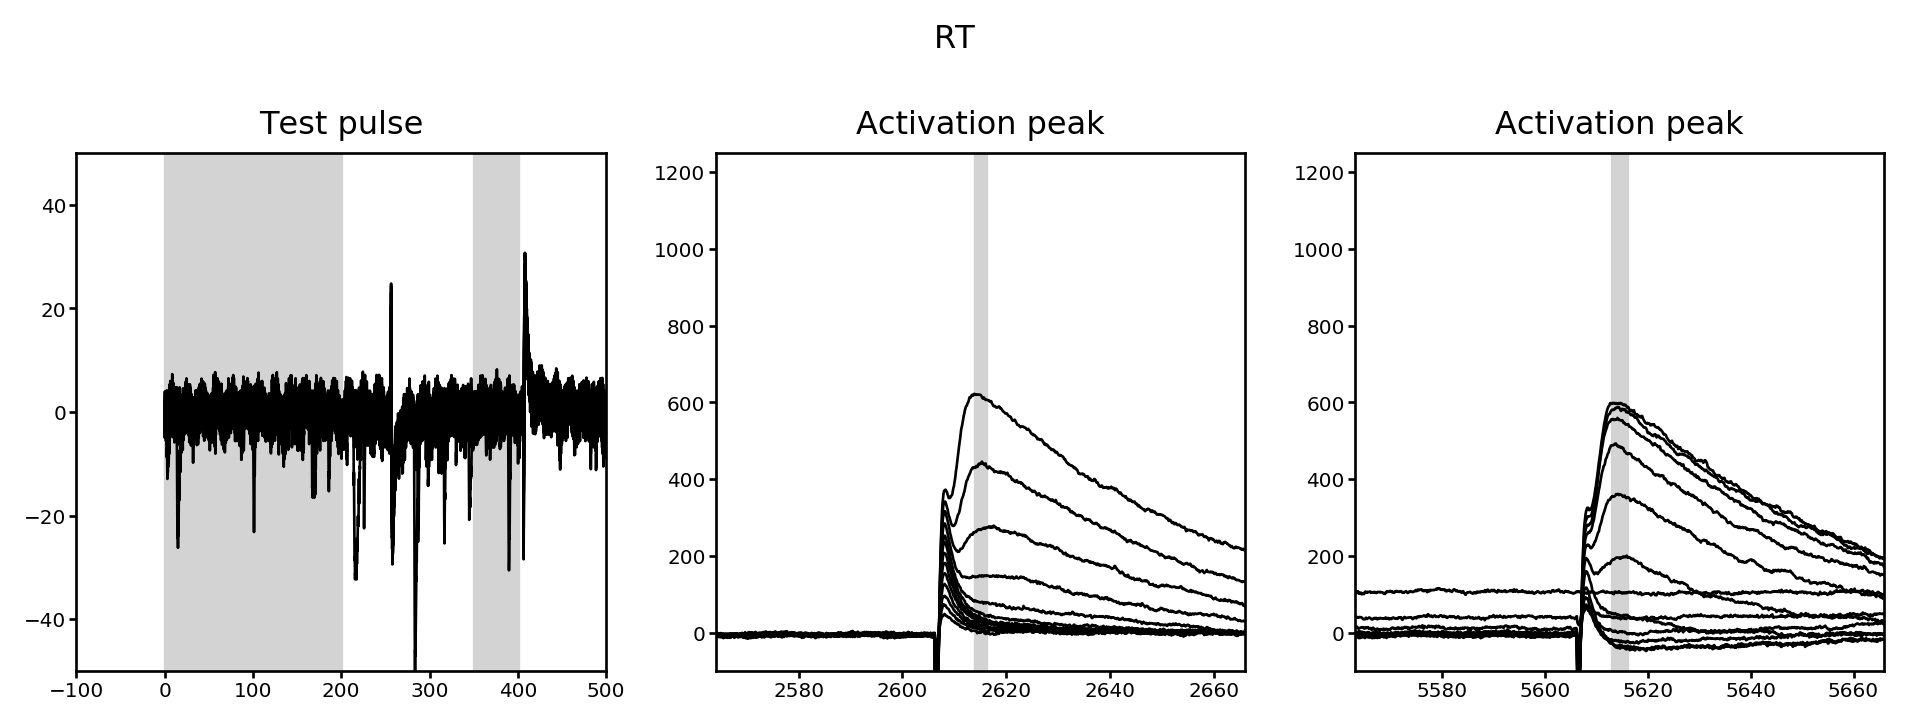

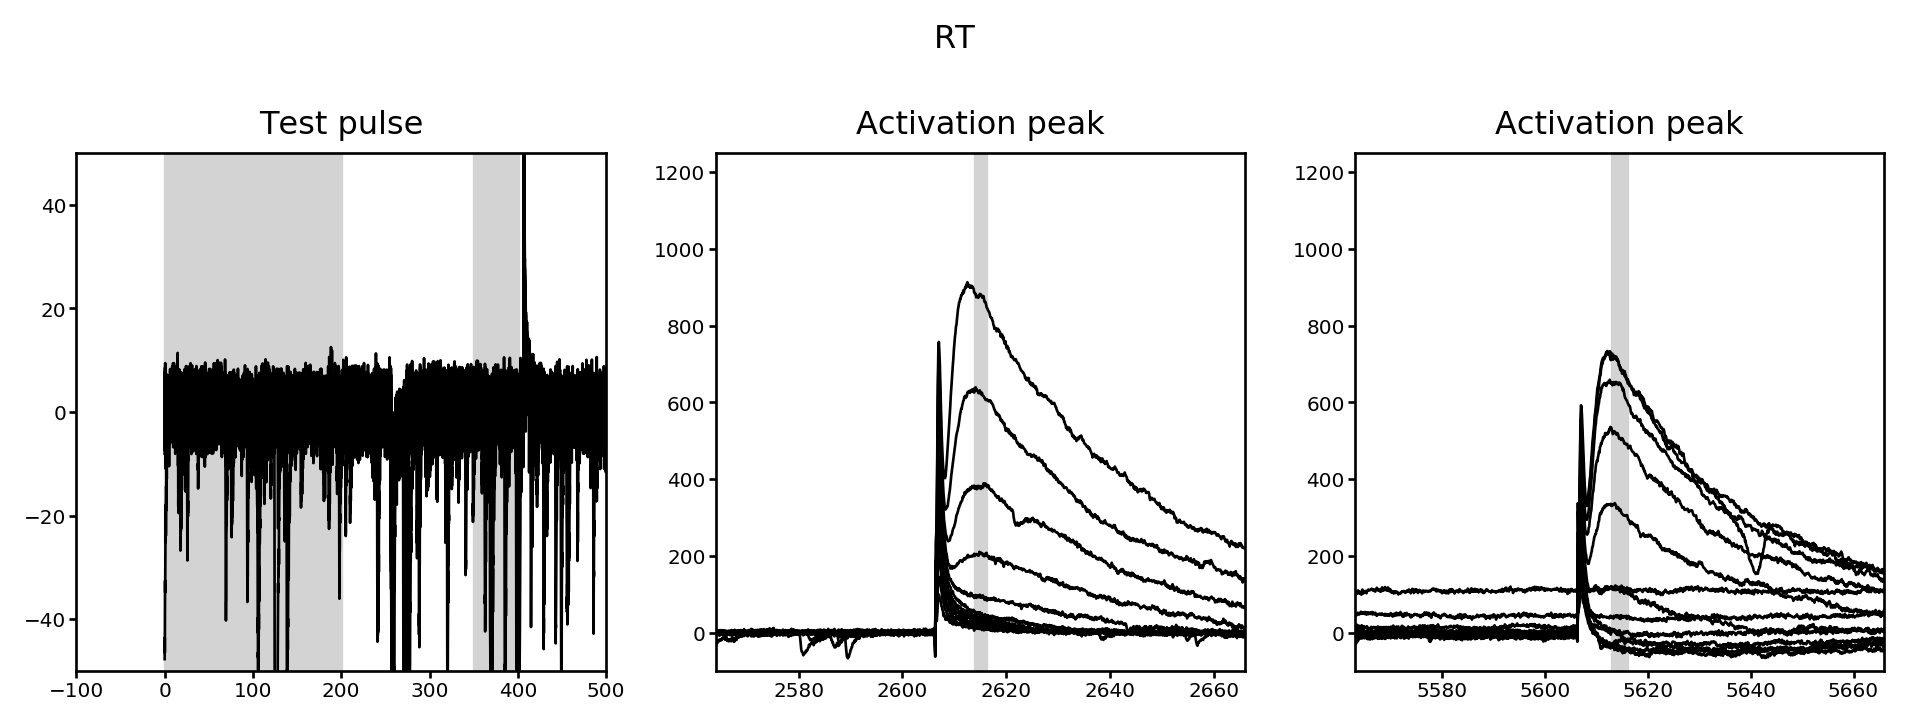

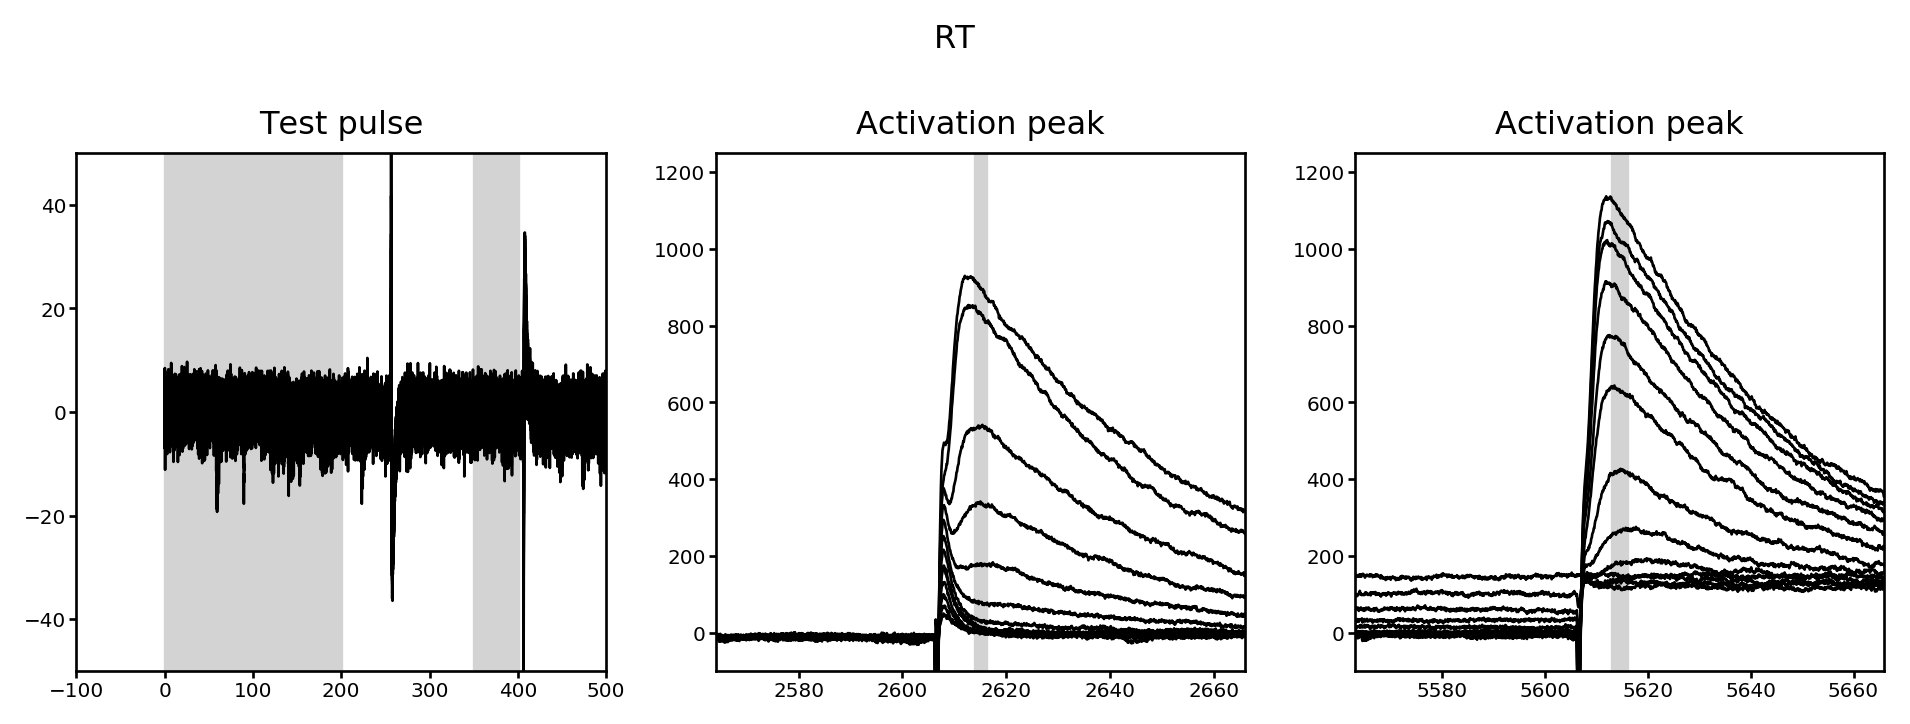

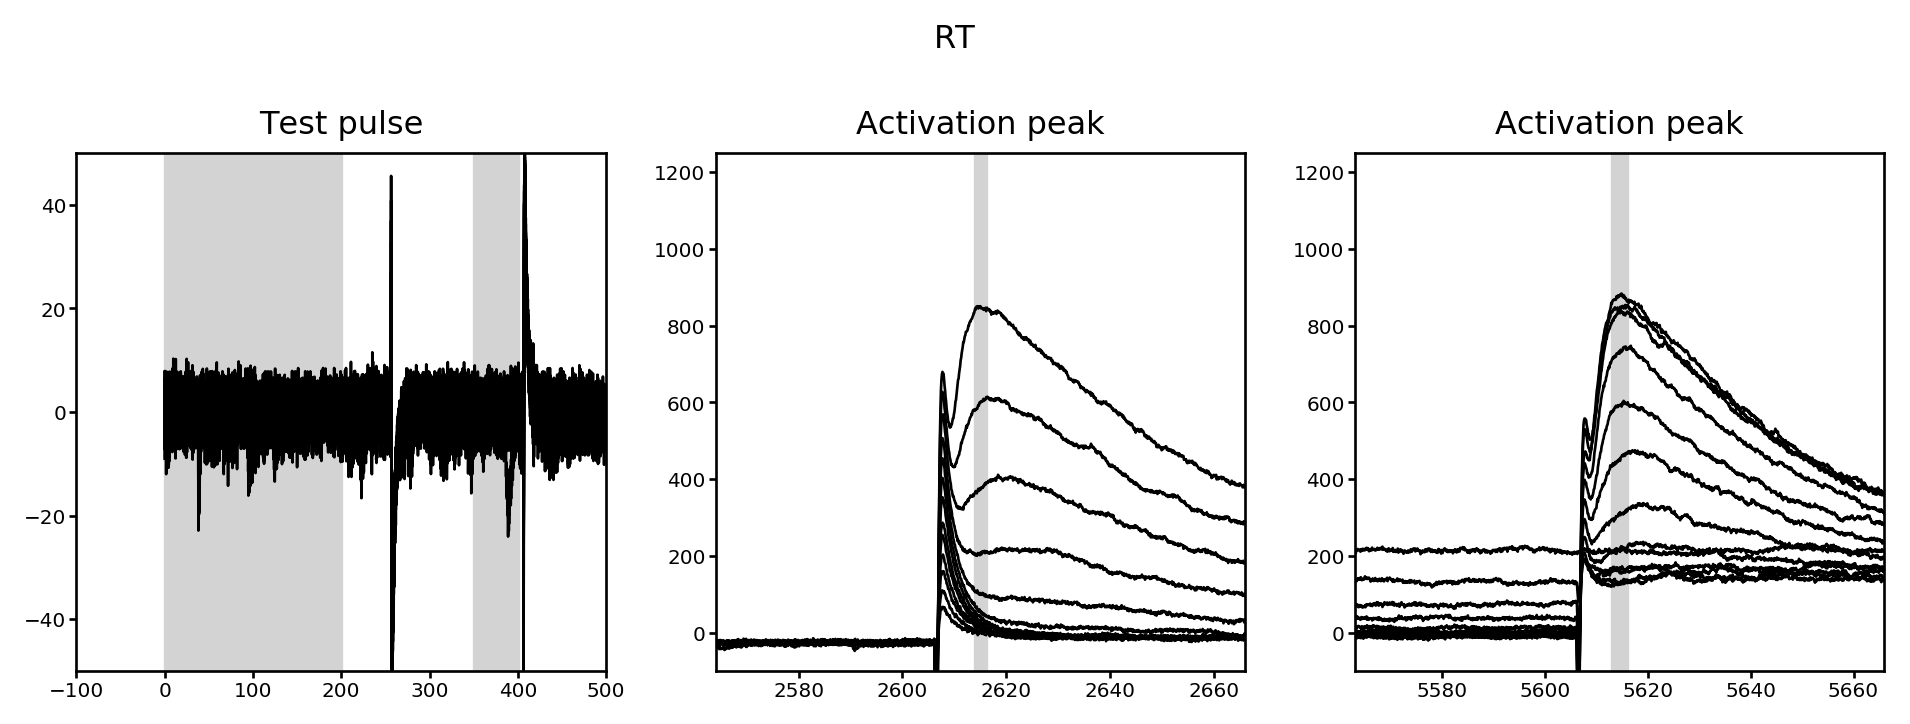

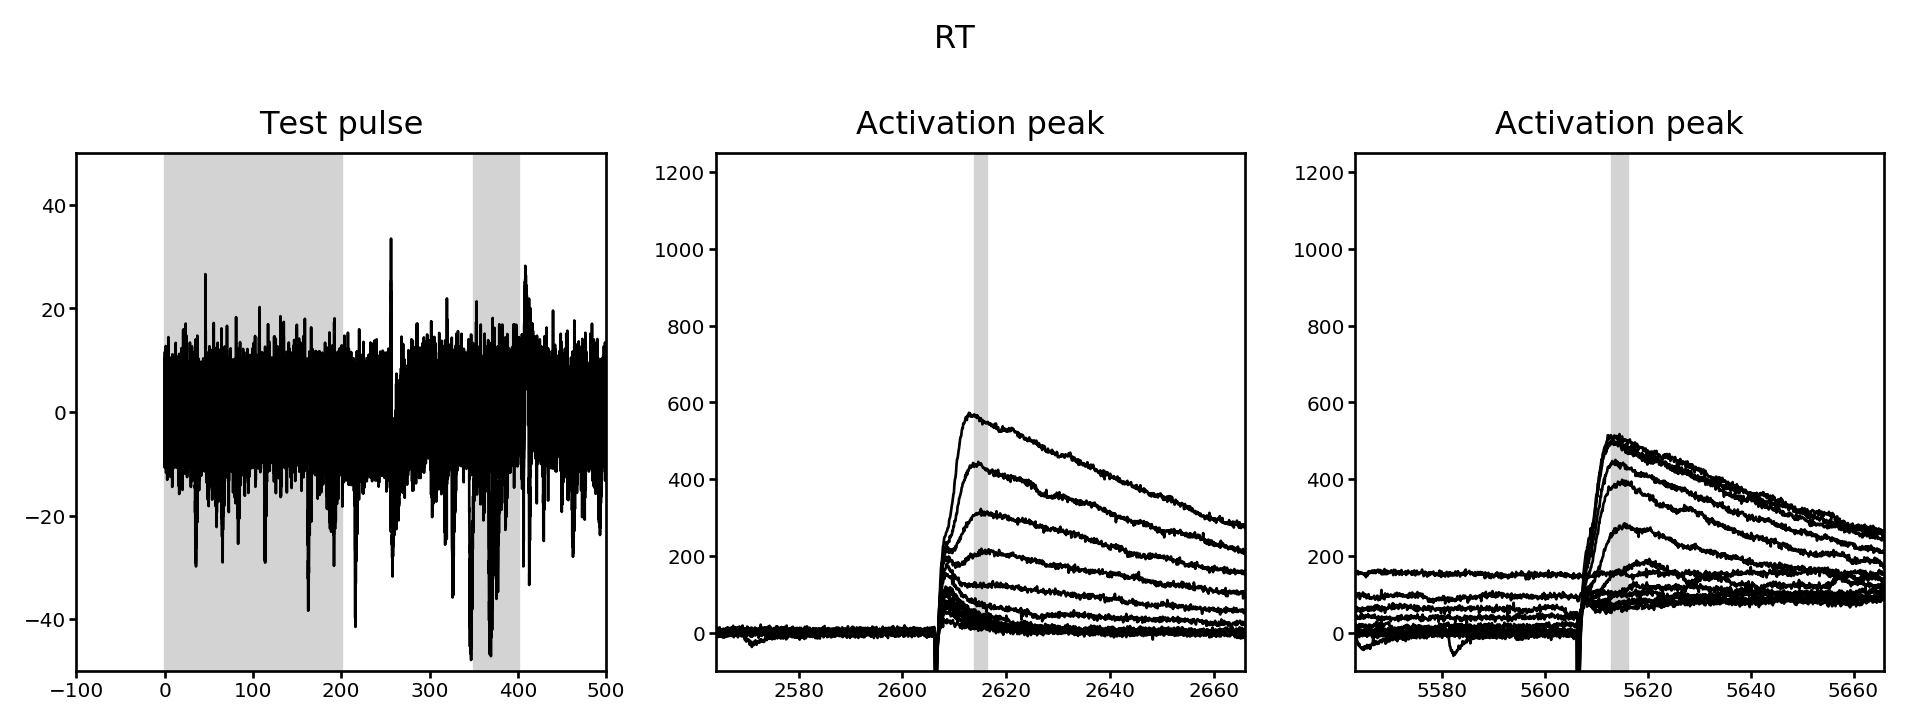

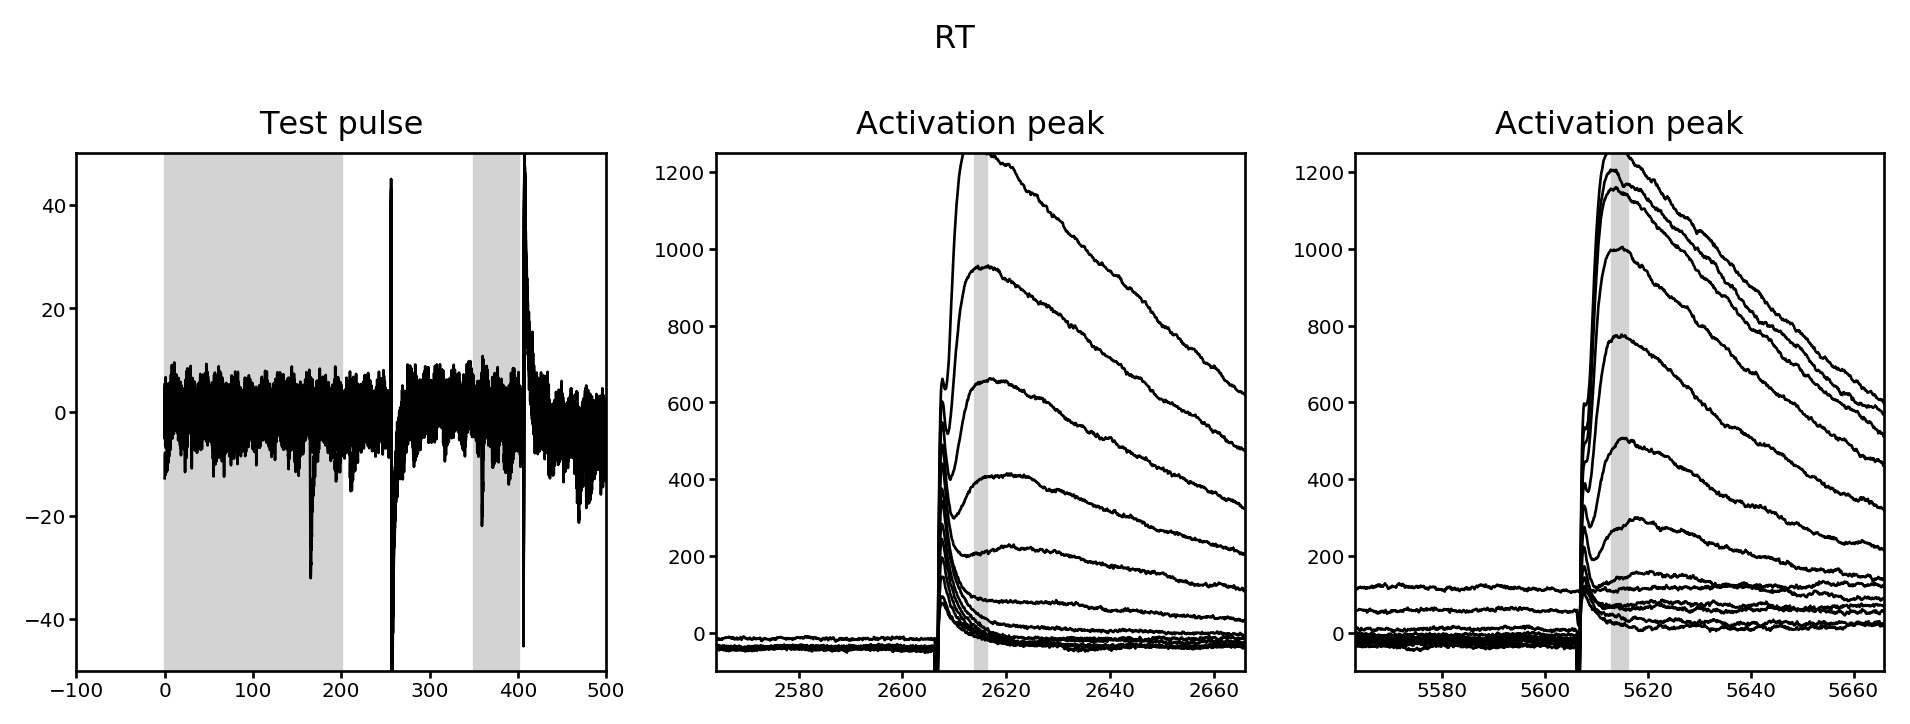

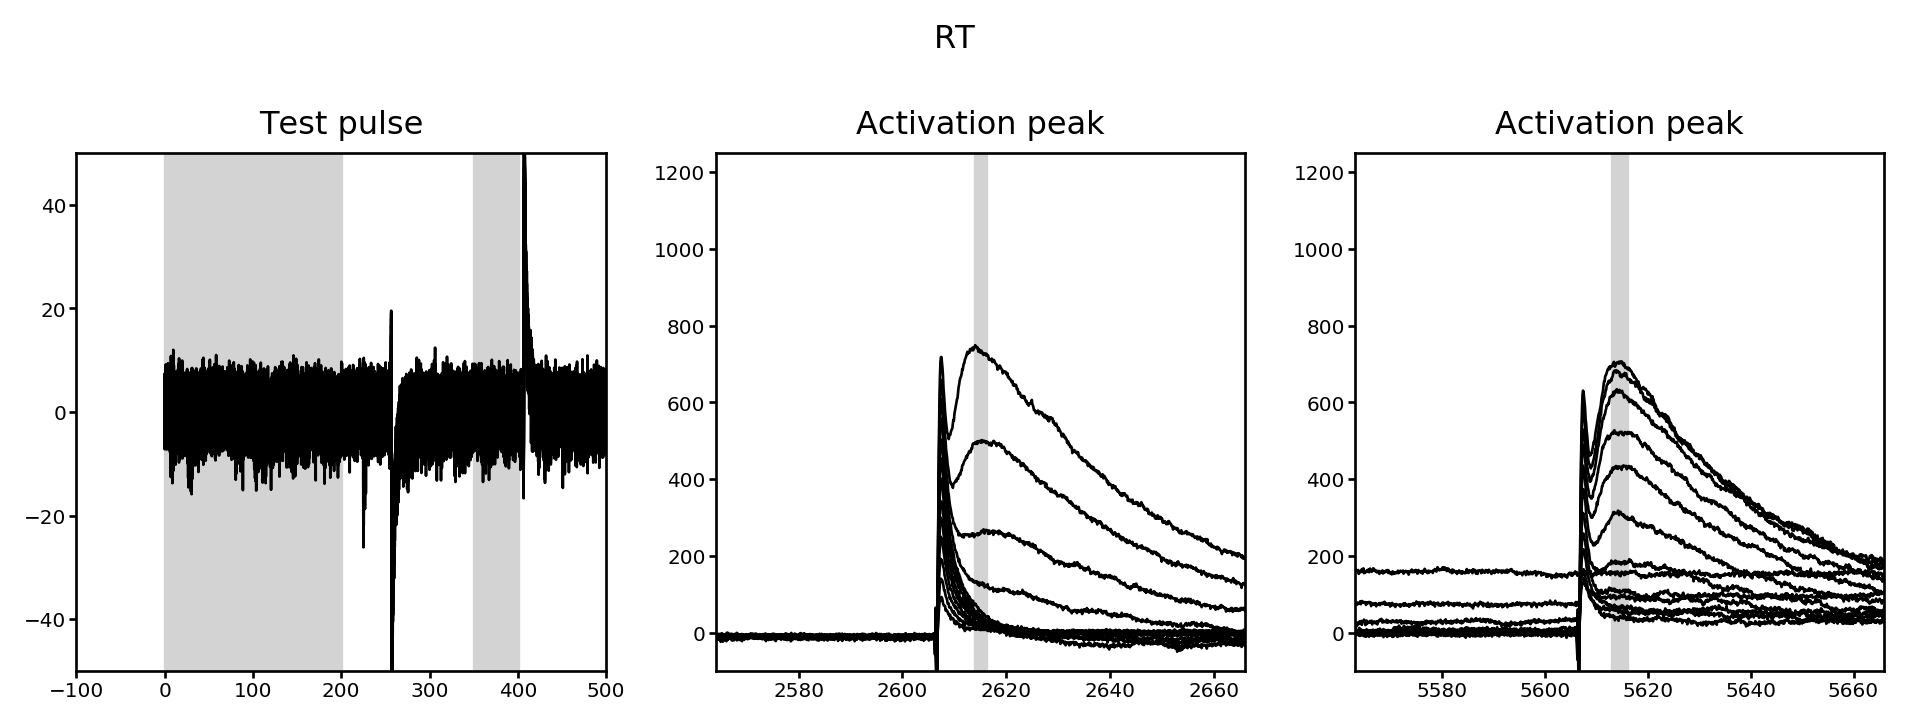

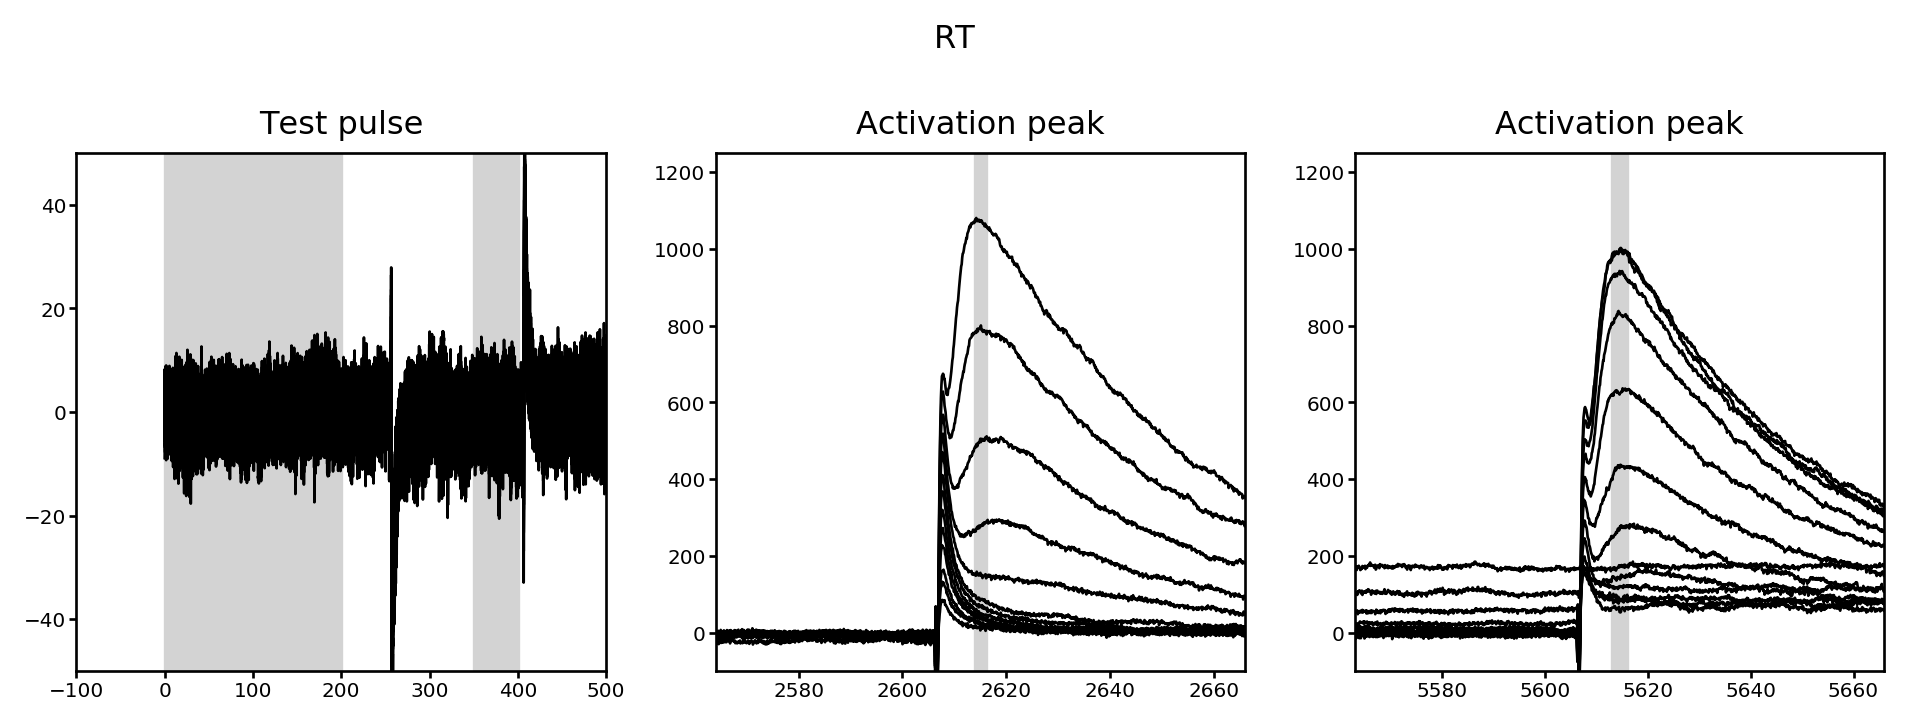

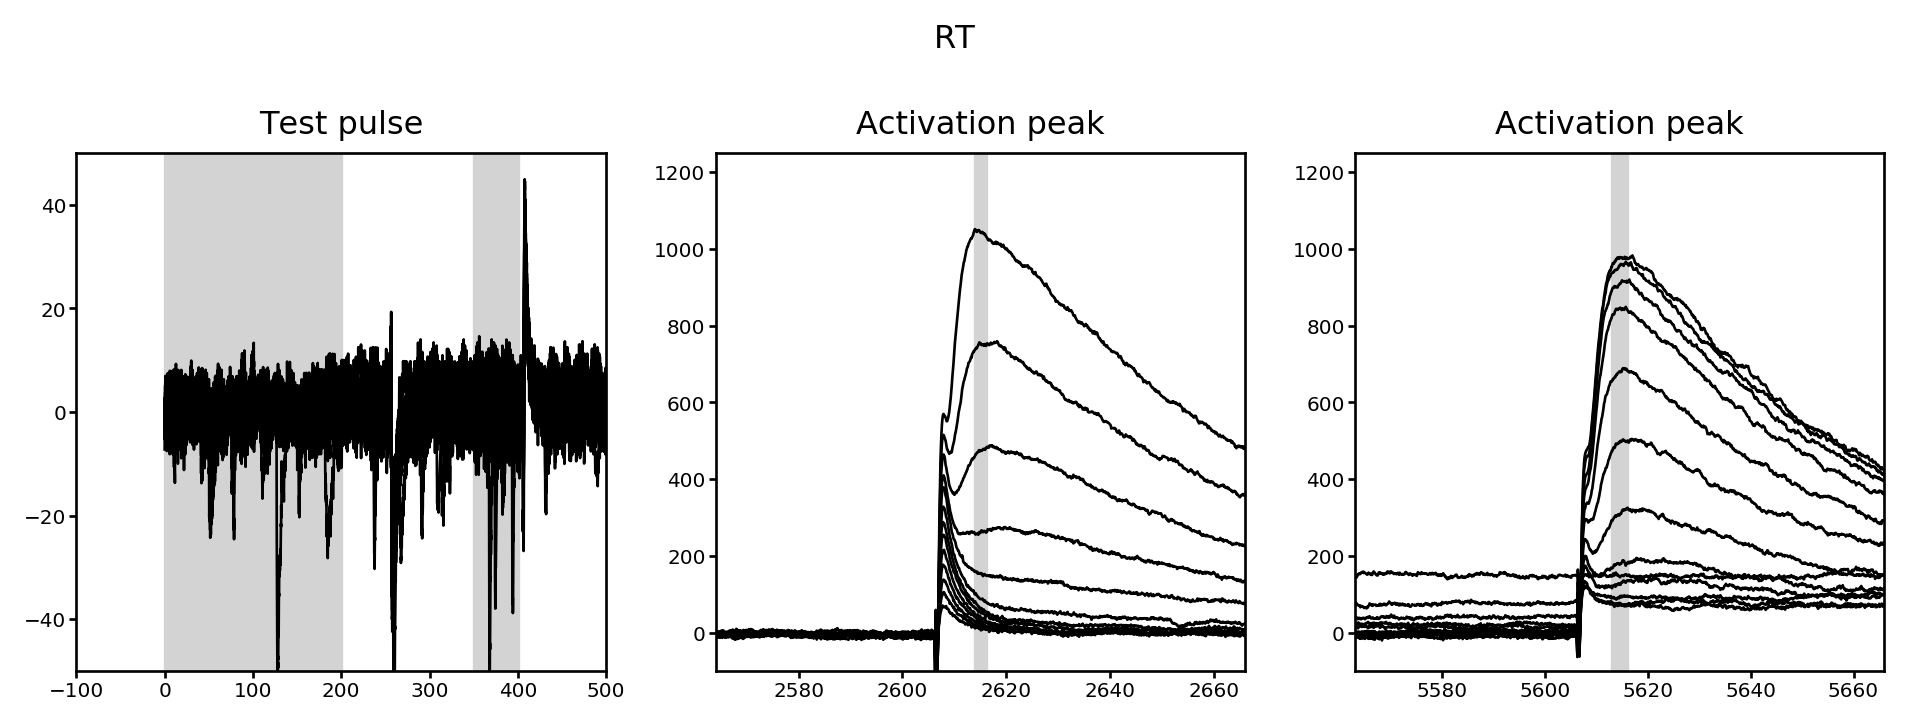

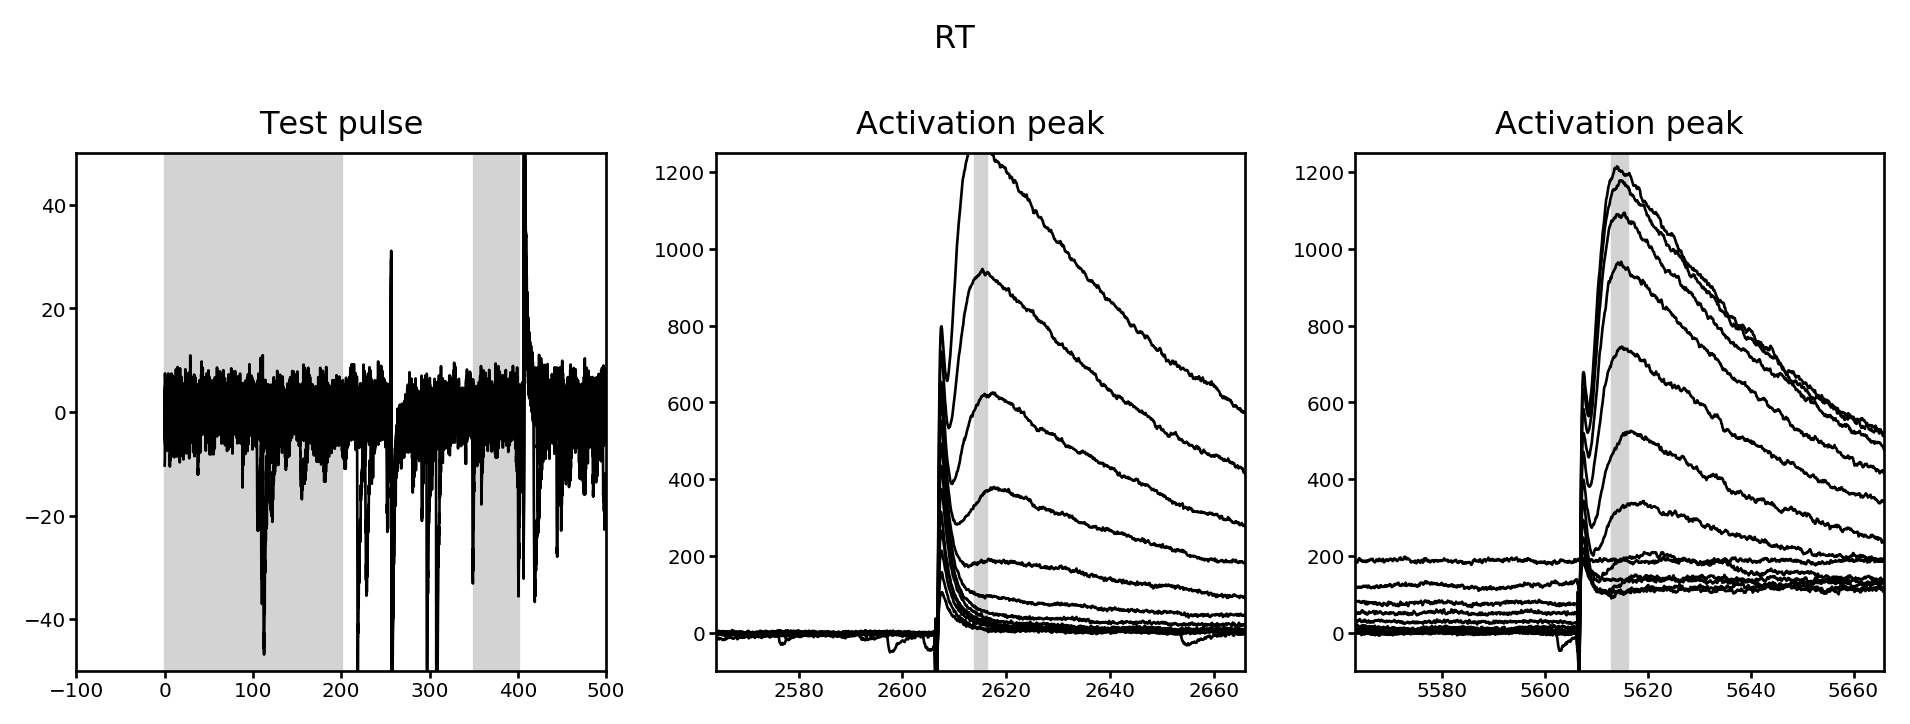

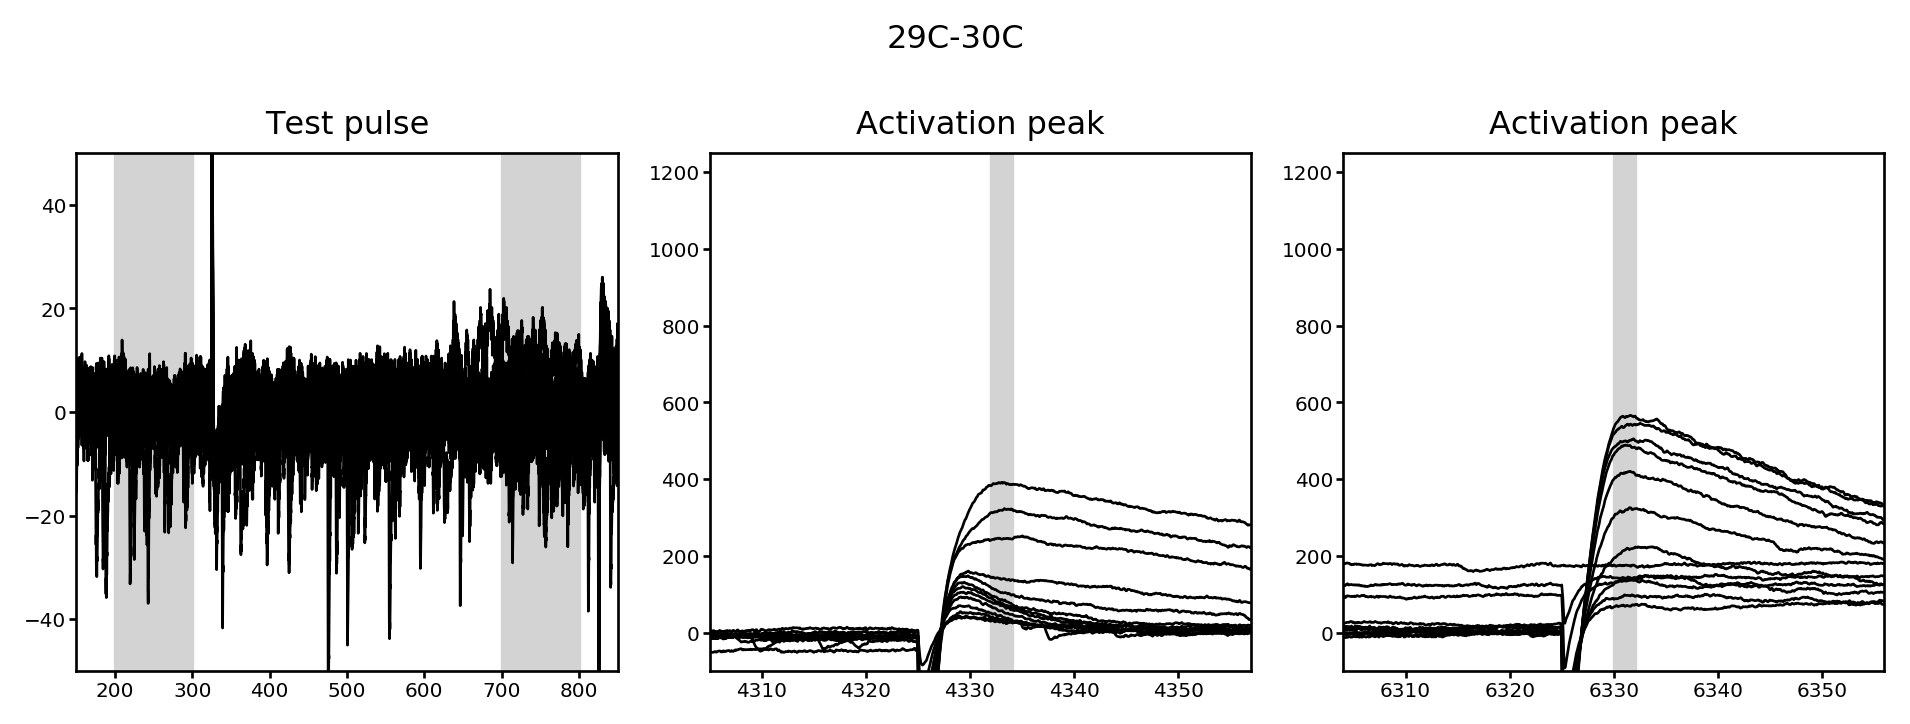

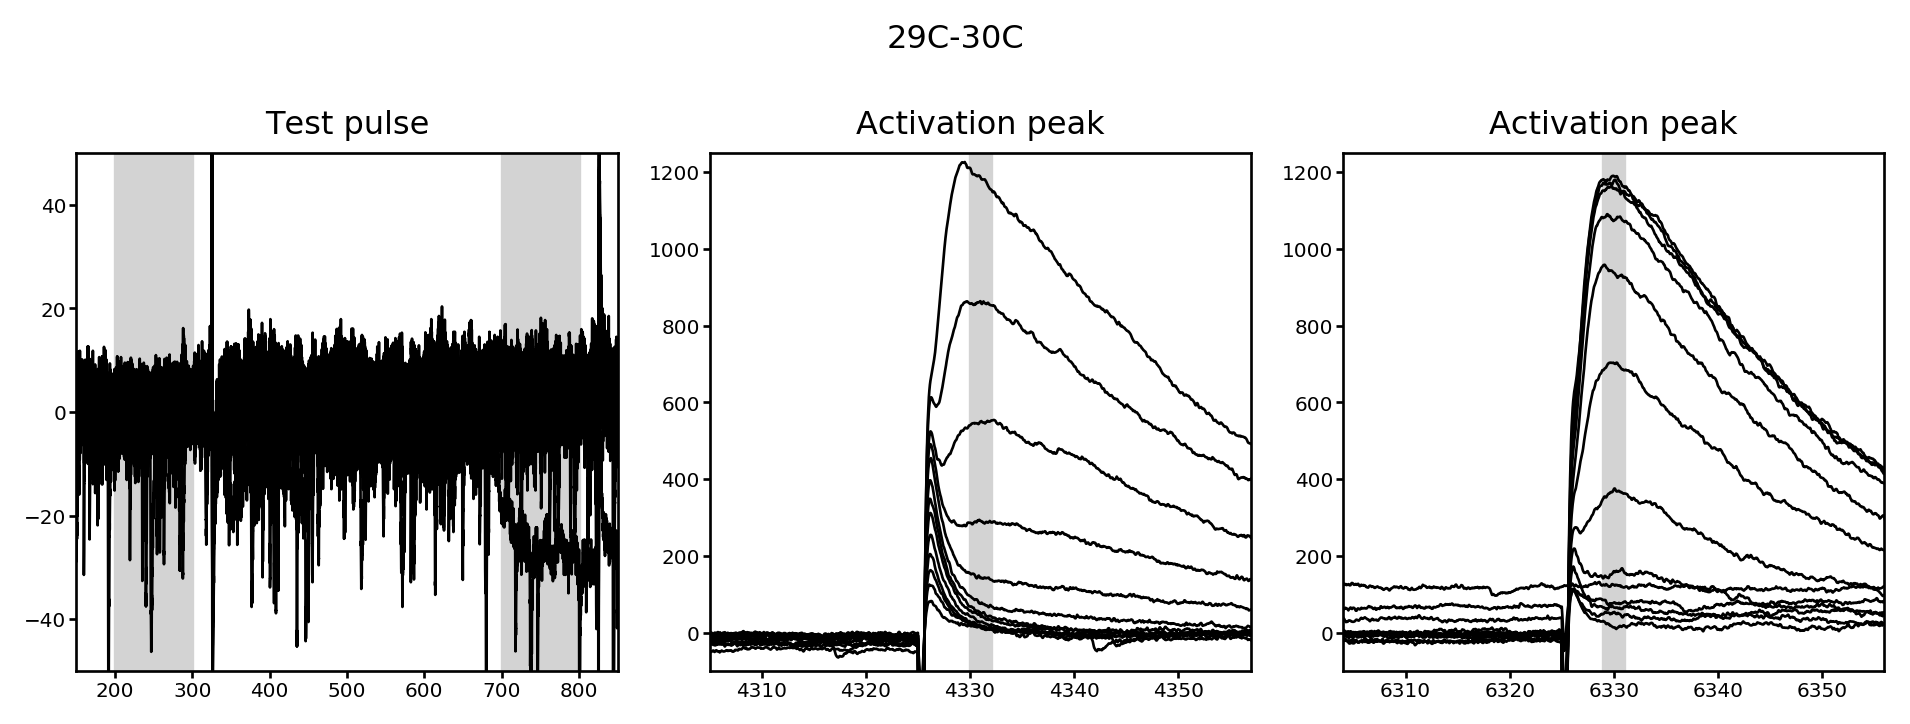

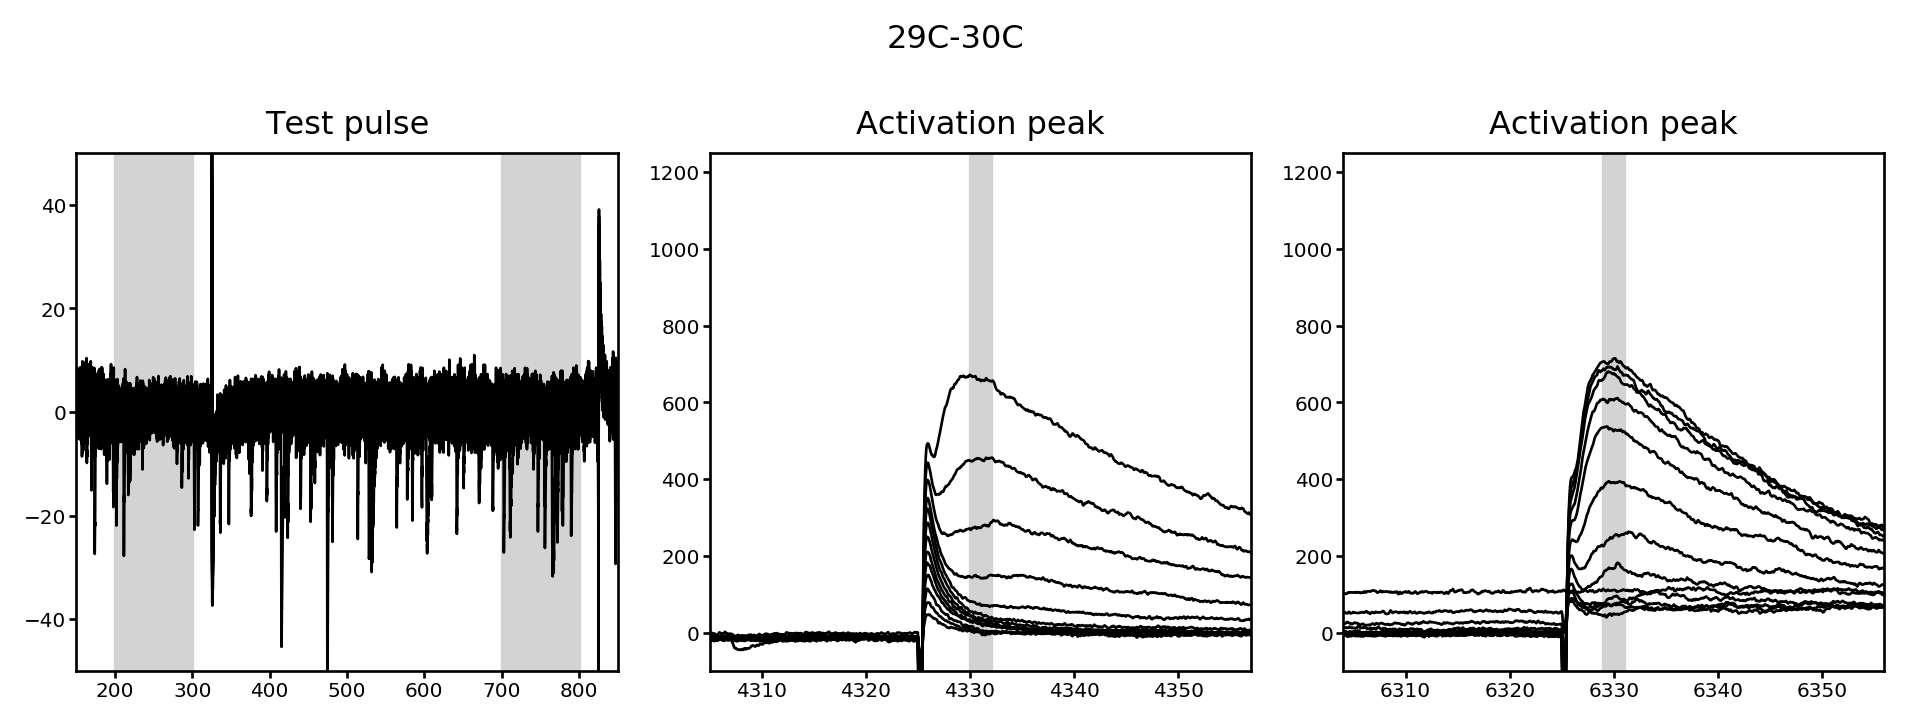

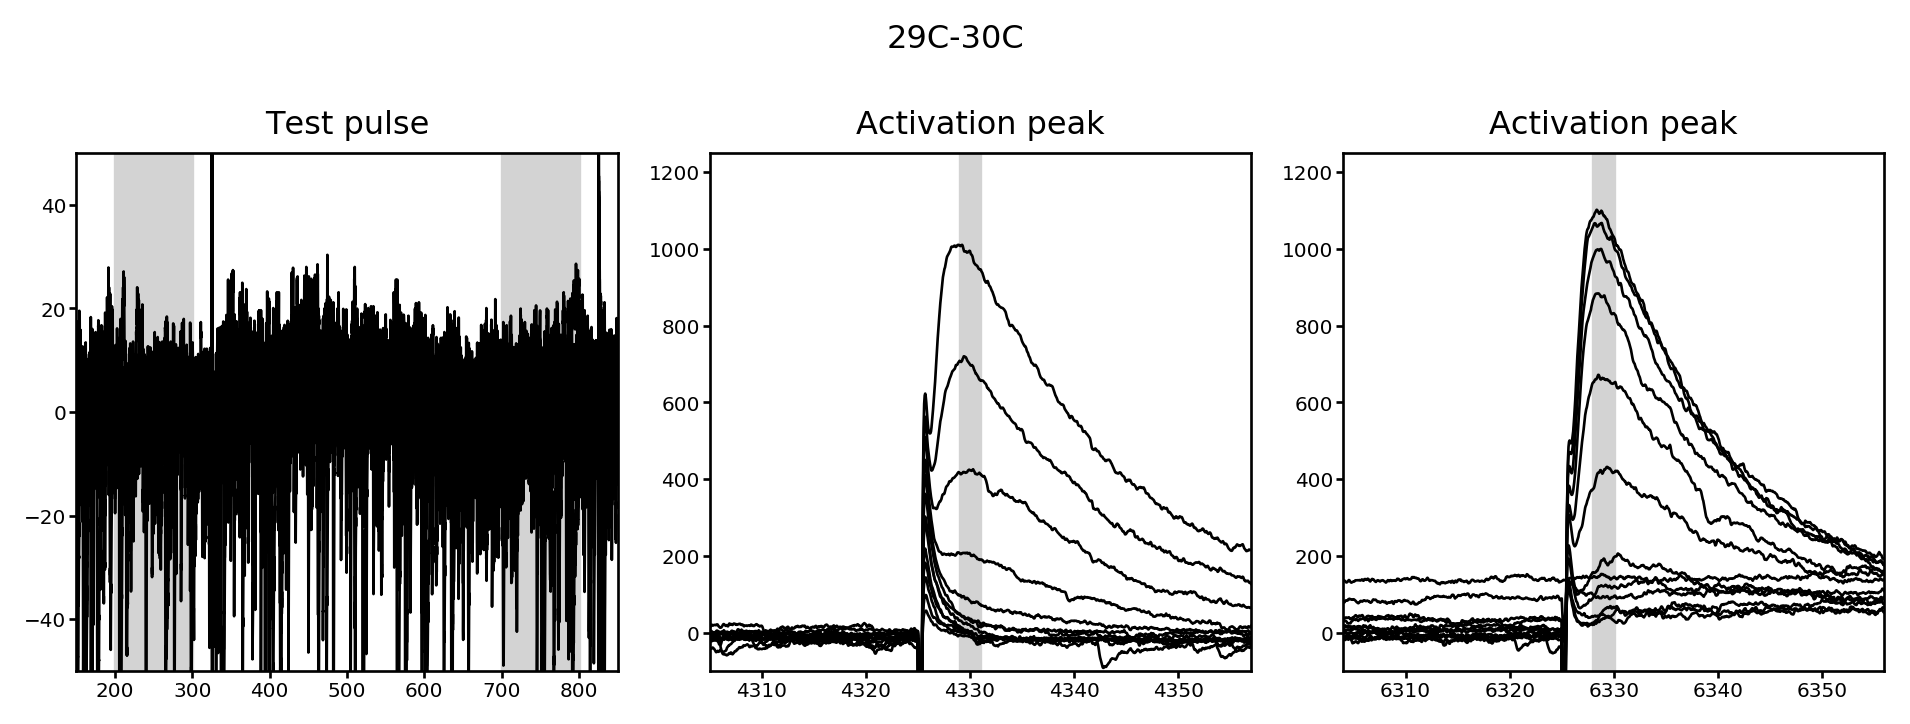

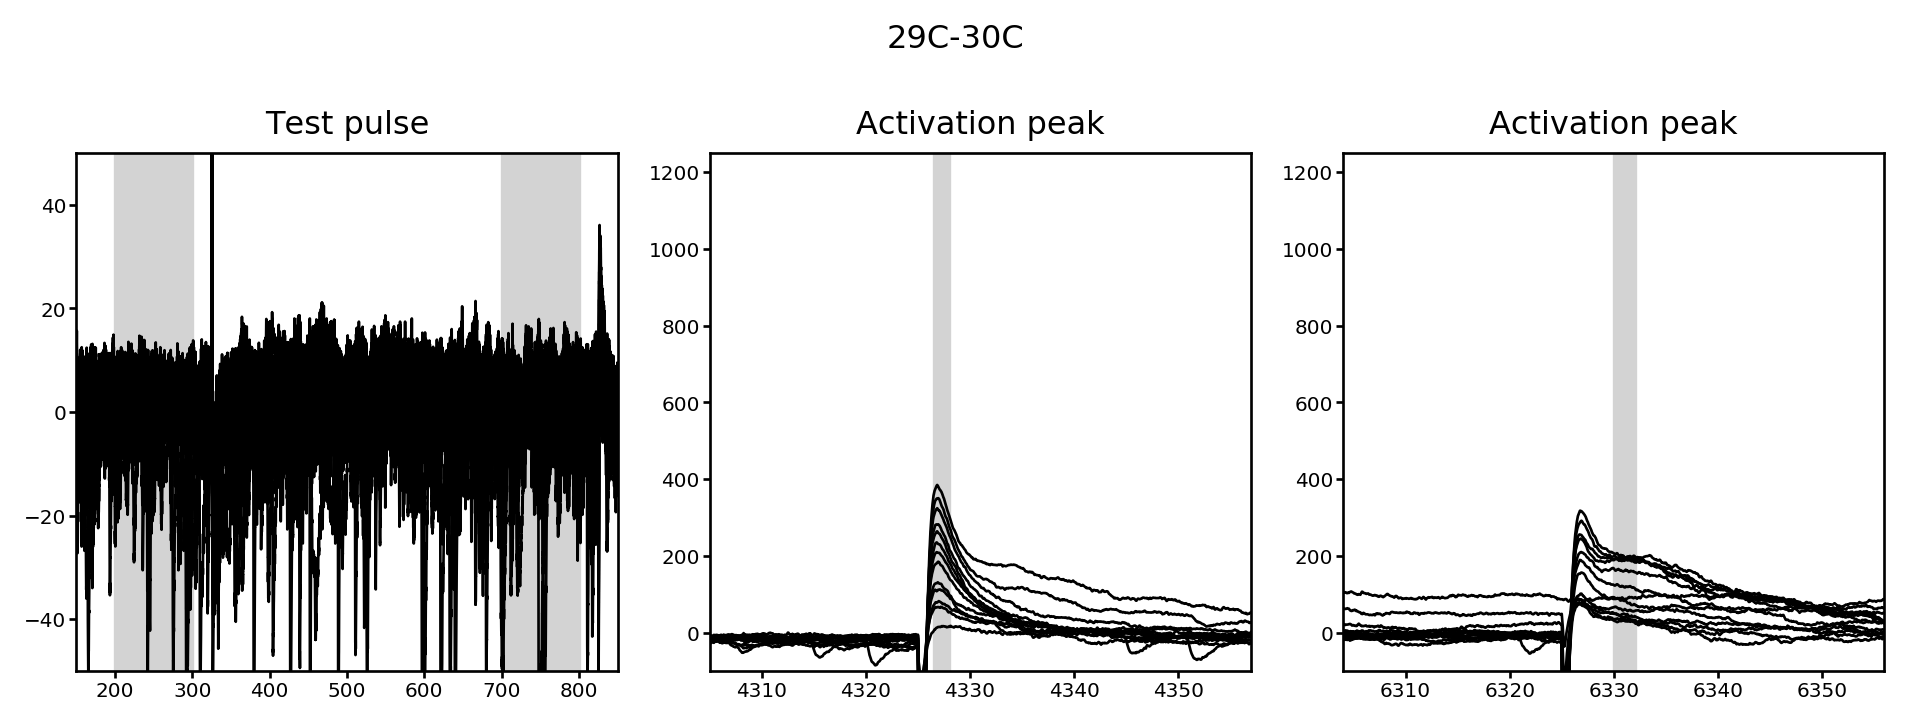

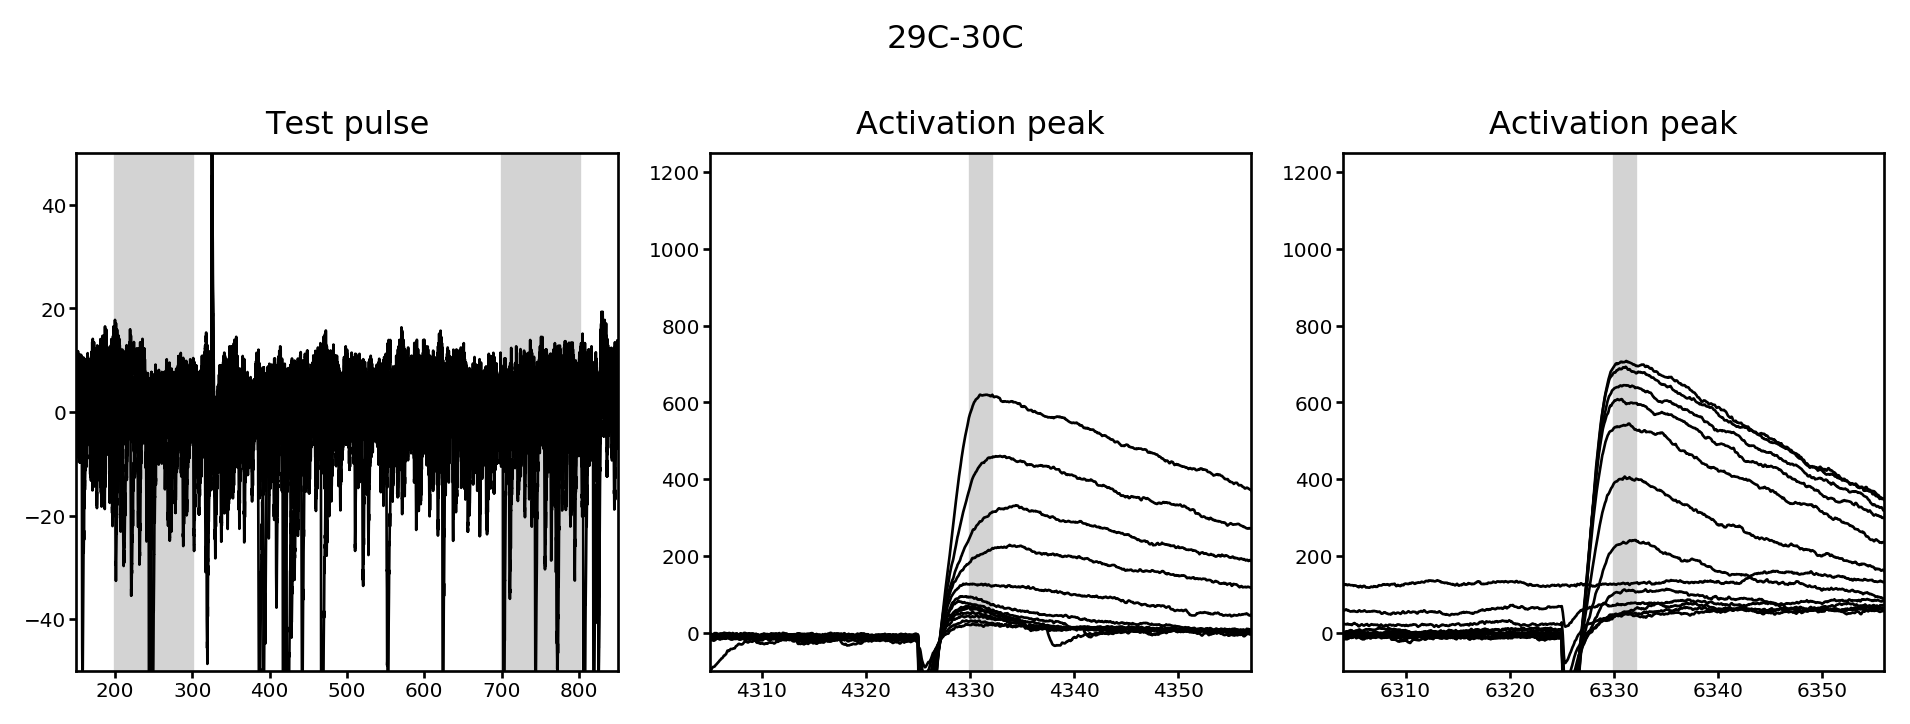

In [9]:
def __plot_processed_current_traces(recording, temp, ax):
    """Dirty helper function to plot traces from the current (I) channel."""
    ax.plot(
        recording.time_supp,
        preprocess_recording(
            recording,
            slice(*gating_time_windows[temp]['windows']['baseline_window']),
            slice(*gating_time_windows[temp]['windows']['test_window']),
            VOLTAGE_CHANNEL,
            CURRENT_CHANNEL,
        )[CURRENT_CHANNEL, ...],
        'k-'
    )

for t, g in gating.iteritems():
    for i, r in enumerate(g):
        fig, axes = plt.subplots(1, 3, figsize=(8, 3))
        fig.suptitle(t)

        mgw = partial(
            mark_time_interval,
            time_unit=gating_time_windows[t]['window_unit'],
            dt=r.dt,
            color='lightgray',
        )

        axes[0].set_title('Test pulse')
        mgw(gating_time_windows[t]['windows']['baseline_window'], ax=axes[0])
        mgw(gating_time_windows[t]['windows']['test_window'], ax=axes[0])
        __plot_processed_current_traces(r, t, axes[0])
        axes[0].set_xlim(np.array(xlims[t]['test_pulse']) * r.dt)
        axes[0].set_ylim(-50, 50)

        axes[1].set_title('Activation peak')
        mgw(
            gating_time_windows[t]['windows']['activation_peak_window'][i],
            ax=axes[1],
        )
        __plot_processed_current_traces(r, t, axes[1])
        axes[1].set_xlim(np.array(xlims[t]['activation']) * r.dt)
        axes[1].set_ylim(-100, 1250)

        axes[2].set_title('Activation peak')
        mgw(
            gating_time_windows[t]['windows']['inactivation_peak_window'][i],
            ax=axes[2],
        )
        __plot_processed_current_traces(r, t, axes[2])
        axes[2].set_xlim(np.array(xlims[t]['inactivation']) * r.dt)
        axes[2].set_ylim(-100, 1250)

        plt.tight_layout()
        plt.subplots_adjust(top=0.8)
        plt.show()
        fig.clf()
        plt.close(fig)

In [10]:
pdata = {
    k: extract_gating_data(
        v,
        window_unit=gating_time_windows[k]['window_unit'],
        **gating_time_windows[k]['windows']
    )
    for k, v in gating.iteritems()
}
pdata['29C-30C']['exclude'] = np.array([False, False, False, False, True, False])
pdata['RT']['exclude'] = np.array([False for _ in range(len(gating['RT']))])

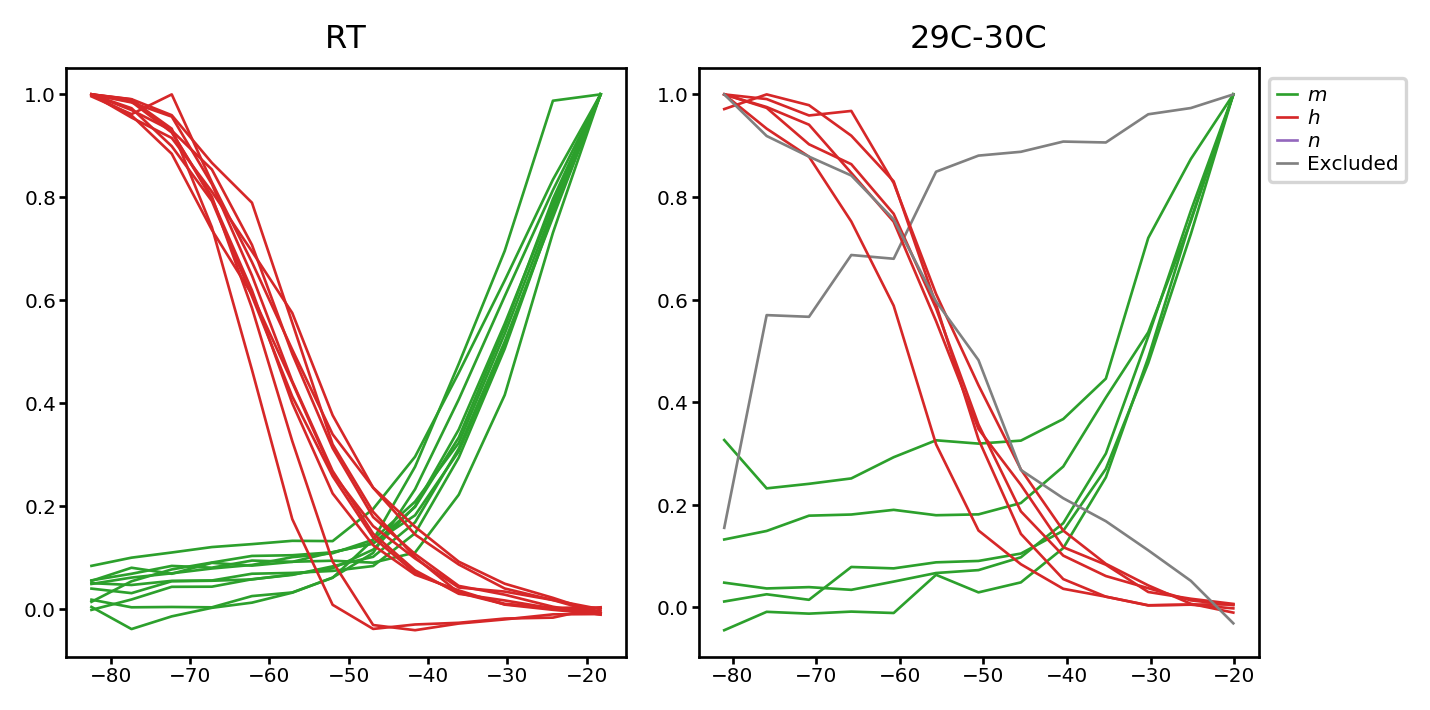

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for ax, temp in zip(axes, ['RT', '29C-30C']):
    _exclude = pdata[temp]['exclude']
    ax.set_title(temp)
    ax.plot(
        pdata[temp]['activation_peak'][1, :, ~_exclude].T,
        max_normalize_channel(
            pdata[temp]['activation_peak'][0, :, ~_exclude].T
        ),
        color=colors['m'],
        label=r'$m_\infty$',
    )
    ax.plot(
        pdata[temp]['activation_peak'][1, :, _exclude].T,
        max_normalize_channel(
            pdata[temp]['activation_peak'][0, :, _exclude].T
        ),
        color='gray',
        label=r'$m_\infty$',
    )

    ax.plot(
        pdata[temp]['inactivation_peak'][1, :, ~_exclude].T,
        max_normalize_channel(
            pdata[temp]['inactivation_peak'][0, :, ~_exclude].T
        ),
        color=colors['h'],
        label=r'$m_\infty$',
    )
    ax.plot(
        pdata[temp]['inactivation_peak'][1, :, _exclude].T,
        max_normalize_channel(
            pdata[temp]['inactivation_peak'][0, :, _exclude].T
        ),
        color='gray',
        label=r'$m_\infty$',
    )

axes[1].legend(
    [
        Line2D([0], [0], color=colors['m']),
        Line2D([0], [0], color=colors['h']),
        Line2D([0], [0], color=colors['n']),
        Line2D([0], [0], color='gray'),
    ],
    ['$m$', '$h$', '$n$', 'Excluded'],
    loc='upper left',
    bbox_to_anchor=(1, 1),
)

plt.tight_layout()
plt.show()

plt.close()

Saving svg
Saving png
Done!


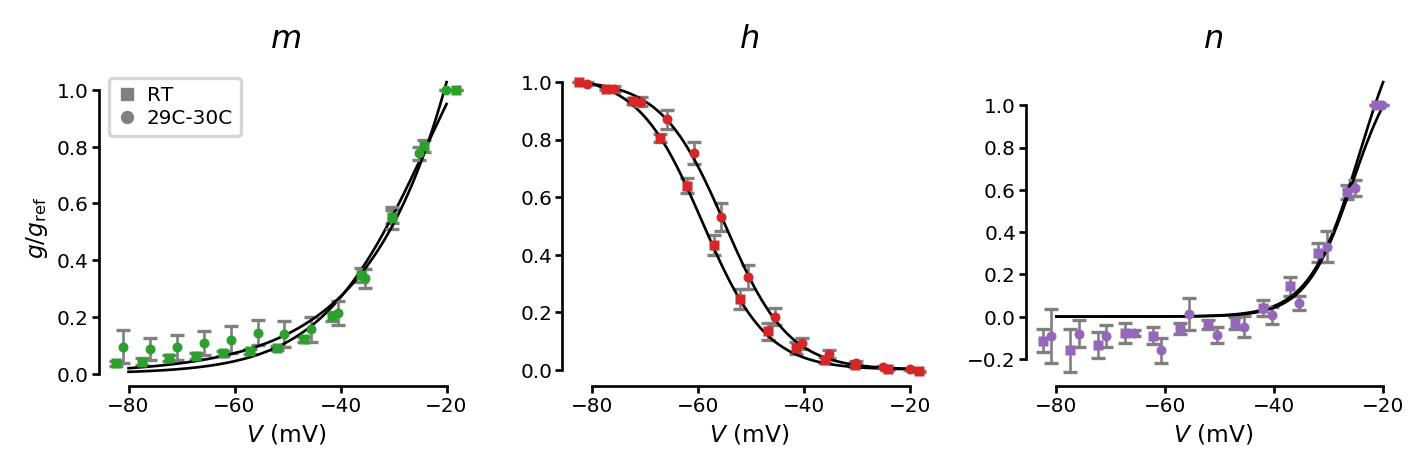

In [12]:
params = {
    'RT': load_gating_params(
        os.path.join(
            os.getenv('DATA_PATH'),
            'processed',
            '5HT',
            'gating_params_room_temp.csv',
        )
    ),
    '29C-30C': load_gating_params(
        os.path.join(
            os.getenv('DATA_PATH'),
            'processed',
            '5HT',
            'gating_params_heated.csv',
        ),
    ),
}

from grr.CurveFit import sigmoid_curve

fig, axes = plt.subplots(1, 3, figsize=(6, 2))

x = np.linspace(-80, -20, 200)
plt_params = {
    'ls': 'none',
    'capsize': 2,
    'ecolor': 'gray',
    'markersize': 3,
    'markeredgecolor': 'none',
}
_temperature_markers = {
    'RT': 's',
    '29C-30C': 'o'
}
_pdata_names = {
    'm': 'activation_peak',
    'h': 'inactivation_peak',
    'n': 'steady_state'
}

for ax, gate in zip(axes, ['m', 'h', 'n']):
    ax.set_title('${}$'.format(gate))
    for temp, marker in _temperature_markers.iteritems():
        ax.errorbar(
            marker=marker,
            color=colors[gate],
            **dict(
                plt_params,
                **get_plot_coordinates_with_error(
                    pdata[temp][_pdata_names[gate]][
                        ..., ~pdata[temp]['exclude']
                    ]
                )
            )
        )
        ax.plot(
            x,
            sigmoid_curve(params[temp][gate].to_numpy(), x),
            color=colors['fit'],
            ls='-',
        )
    ax.set_xlabel('$V$ (mV)')
    pltools.hide_border('tr', trim=True, ax=ax)

axes[0].set_ylabel('$g/g_\mathrm{ref}$')
axes[0].legend(
    handles=[
        Line2D([0], [0], marker=m, color='gray', label=l, markersize=2, ls='none')
        for l, m in _temperature_markers.iteritems()
    ],
    loc='upper left',
)

plt.tight_layout()

savefig(os.path.join(os.getenv('IMG_PATH'), 'ser_gating_temp_comparison'))

## Kinetics and amplitude

In [13]:
kin_rt = pd.read_csv(
    os.path.join(
        os.getenv('DATA_PATH'), 'processed', '5HT', 'transient_current_parameters.csv'
    )
)
kin_rt['temperature'] = 'RT'
kin_heated = pd.read_csv(
    os.path.join(
        os.getenv('DATA_PATH'), 'processed', '5HT', 'transient_current_parameters_heated.csv'
    )
)
kin_heated['temperature'] = '29C-30C'
kin = pd.concat([kin_rt, kin_heated])
del kin_rt, kin_heated
kin['peak_amplitudes_nA'] = kin['peak_amplitudes'] / 1e3
kin.head()

,inactivation_taus,peak_amplitudes,peak_conductance,peak_exists,peak_latencies,steady_state_amplitudes,steady_state_conductance,temperature,peak_amplitudes_nA
0,39.280178,616.019392,7.605178,True,7.7,97.607349,1.205029,RT,0.616019
1,28.866688,921.168675,11.372453,True,6.3,107.386440,1.325759,RT,0.921169
2,32.445161,935.471419,11.549030,True,5.8,170.499481,2.104932,RT,0.935471
3,40.782865,855.081312,10.556559,True,8.3,220.519097,2.722458,RT,0.855081
4,49.629096,578.376225,7.140447,True,6.6,166.533216,2.055966,RT,0.578376


Saving svg
Saving png
Done!


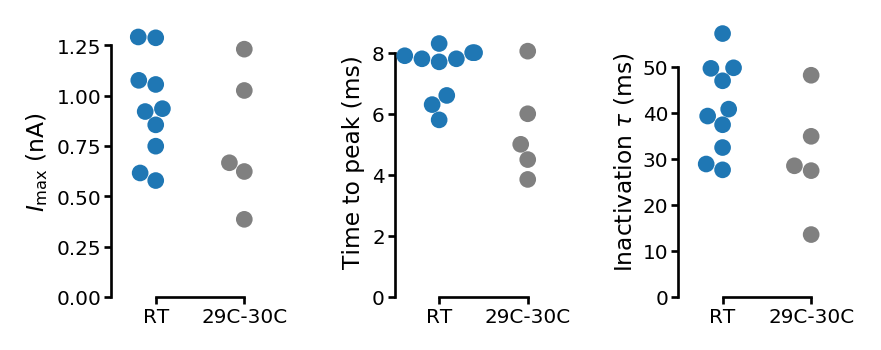

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(4, 1.5), gridspec_kw={'wspace': 0.6})

axes[0].set_ylim(0, 1.35)
sns.swarmplot(
    'temperature', 'peak_amplitudes_nA', data=kin.query('peak_exists'), ax=axes[0],
    palette=[colors['ser'], 'gray']
)
pltools.hide_border('tr', trim=True, ax=axes[0])
axes[0].set_ylabel('$I_\\mathrm{max}$ (nA)')
axes[0].set_xlabel('')

axes[1].set_ylim(0, 8.9)
sns.swarmplot(
    'temperature', 'peak_latencies', data=kin.query('peak_exists'), ax=axes[1],
    palette=[colors['ser'], 'gray']
)
pltools.hide_border('tr', trim=True, ax=axes[1])
axes[1].set_ylabel('Time to peak (ms)')
axes[1].set_xlabel('')

axes[2].set_ylim(0, 59)
sns.swarmplot(
    'temperature', 'inactivation_taus', data=kin.query('peak_exists'), ax=axes[2],
    palette=[colors['ser'], 'gray']
)
pltools.hide_border('tr', trim=True, ax=axes[2])
axes[2].set_ylabel('Inactivation $\\tau$ (ms)')
axes[2].set_xlabel('')


savefig(os.path.join(os.getenv('IMG_PATH'), 'ser_kinetics_temp_comparison'))